In [1]:
%load_ext autoreload
%autoreload 2 

# Deep learning tips and tricks: Data augmentation and Transfer learning

**What you will learn today**: You will learn how to improve the performance of a deep neural network by increasing the effective data available for training using data augmentation. You will also learn how to leverage large pretrained models to boost the performance of a downstream task using transfer learning.

## On the previous episode...

On the previous lab we explored different techniques to train neural networks and implemented them using `PyTorch`. Our experiments showed that choosing the right learning rate and architecture are fundamental to generalize on a complex dataset such as CIFAR10. We learned how modern optimizers work, and explored new architectural concepts such as batch normalization and skip connections.

In this lab, we will continue this journey and investigate other techniques to improve performance of a neural network. In particular, we will see how one can exploit the flexibility of stochastic gradient descent to increase our effective data available, and how we can leverage large pretrained models to initialize our networks in a smart way.

Specifically, we will talk about:
* Data augmentation
* Transfer learning

So... let's get started!


For convenience, we copy-paste the necessary code from the previous lab. 

For every model we want to create, we will create a new class that inherits `BasicModel` and implemements the `__init__` and `forward` functions. 

# Data augmentation
Data augmentation is a training technique which consists in transforming every batch of data shown to the model using some random operation which generates a new ''view'' of each sample that retains its semantic information. For example, in the context of image classification, the label of most objects remains the same if you mirror them horizontally. Therefore, a cheap way to increase your training data, is to ''augment'' each sample by introducing its mirrored counterpart.

Let's do it!

In [2]:
# first we load all the necessary libraries
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

from training_utils import fit, predict, plot_loss, visualize_images

In `PyTorch`, the data augmentation operations are included in the transformation pipeline of a dataset. You can find more details on the [official documentation](https://pytorch.org/vision/stable/transforms.html).

In [3]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip() # We want to randomly apply a random flip to every sample
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(), 
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=test_transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In `PyTorch`, any `nn.Module` can be included in a transform pipeline. Every time you ask for a sample `x`, `PyTorch` calls `transform.forward(x)` before feeding it to the model. This means we can easily visualize the effect of data augmentation.

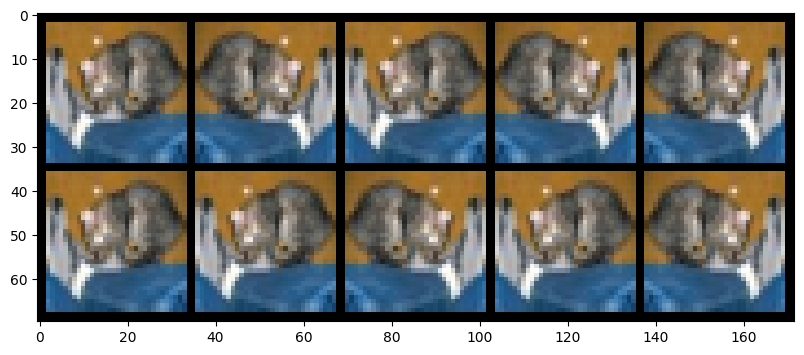

In [4]:
im, _ = test_dataset[0]
im = im[None, ...] # We need a leading batch dimension to feed to the model

images_rot = torch.cat([T.RandomHorizontalFlip()(im) for _ in range(10)])

grid = torchvision.utils.make_grid(images_rot, nrow=5, padding=2)
# Just normalization for test data
plt.figure(figsize=(20,4))
plt.imshow(grid.permute([1,2,0]))

Horizontal flips are a bit obvious. We can get more creative with data augmentation. However, bare in mind that some transformations might destroy important information of your data, so be careful when applying it.

CIFAR10 is relatively easy, so the following transformations are enough to achieve good performance.

In [5]:
train_transform = T.Compose([
    T.ToTensor(),
    T.RandomHorizontalFlip(),
    T.RandomCrop(size=[32,32], padding=4)
])

# We do not want to augment the test data, so we need a different transform pipeline
test_transform = T.Compose([
    T.ToTensor(), 
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=train_transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=test_transform)

# we make the Batch_sizes smaller for computational reasons
# we will later use larger models and memory might become an issue
BATCH_SIZE = 256

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Let's train a **ResNet**! Since it is a standard model, it is already implemented in the `torchvision` library and we can use it directly.

Epoch 0: Loss=1.9331368566775808
Epoch 1: Loss=1.5173916141597592
Epoch 2: Loss=1.299075887519486
Epoch 3: Loss=1.1616401565926415
Epoch 4: Loss=1.010775344104183
Epoch 5: Loss=0.9345221860068185
Epoch 6: Loss=0.8689187886763592
Epoch 7: Loss=0.810903018226429
Epoch 8: Loss=0.7713168336420643
Epoch 9: Loss=0.7255902527546396
Epoch 10: Loss=0.6854150009398557
Epoch 11: Loss=0.6748881741445891
Epoch 12: Loss=0.6316427228098013
Epoch 13: Loss=0.6146328453810848
Epoch 14: Loss=0.5864669607610119
Epoch 15: Loss=0.5717889616379932
Epoch 16: Loss=0.561227450109258
Epoch 17: Loss=0.5434494388042664
Epoch 18: Loss=0.5242759828664818
Epoch 19: Loss=0.5110729137549594
Epoch 20: Loss=0.48965692854657467
Epoch 21: Loss=0.4812049762326844
Epoch 22: Loss=0.46932994848003196
Epoch 23: Loss=0.46199855223602176
Epoch 24: Loss=0.4446346400951853
Epoch 25: Loss=0.43954581554446903
Epoch 26: Loss=0.4230418059290672
Epoch 27: Loss=0.4163252826856107
Epoch 28: Loss=0.4185796454548836
Epoch 29: Loss=0.4009344

(0.9505306736946106, tensor(72., device='cuda:0'))

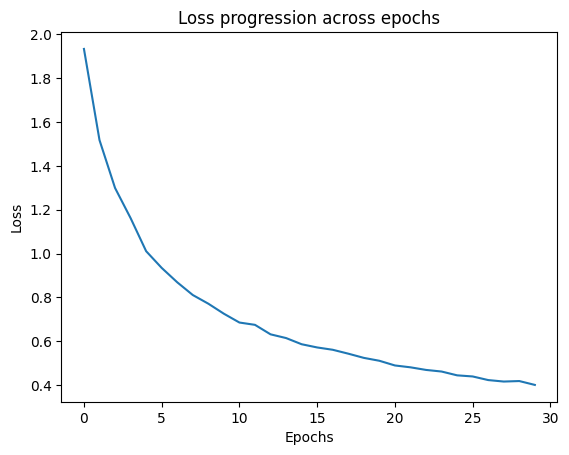

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchvision.models.resnet import resnet18

model = resnet18(num_classes=10).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 30,
        device = DEVICE
    )
)

# predict with the trained model
predict(
        model,
        test_dataloader = test_dataloader,
        device = DEVICE,
    )

# Transfer learning

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.

Transfer learning refers to the concept of initializing a neural network using the weights learned on a different task before training. Surprisingly, if the pretraining dataset is large enough, but also semantically ''close'' to the downstream task, using transfer learning, instead of regular training from random weights can significantly boost performance. Intuitively, transfer learning allows to recycle the features learned with a lot of data on the pretraining task, and leverage them to classify a new dataset.

Let's see this in practice. To that end, we will follow the [PyTorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which is an excellent resource to learn how to implement advanced techniques in deep learning. We will minimally adapt the code to fit our streamlined API from the previous labs.

Let's download our data...

In [9]:
import requests
import os

remote_url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'

local_file = './data/hymenoptera_data.zip'
os.makedirs('./data', exist_ok=True)

data = requests.get(remote_url)

# Save file data to local copy
with open(local_file, 'wb')as file:
    file.write(data.content)

and extract it...

In [10]:
from zipfile import ZipFile
  
# opening the zip file in READ mode
with ZipFile(local_file, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall('./data')
    print('Done!')

File Name                                             Modified             Size
hymenoptera_data/                              2017-03-13 19:21:46            0
hymenoptera_data/train/                        2017-03-13 19:20:02            0
hymenoptera_data/train/ants/                   2017-03-13 19:20:02            0
hymenoptera_data/train/ants/0013035.jpg        2017-03-13 19:19:50        46706
hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg 2017-03-13 19:19:50       174618
hymenoptera_data/train/ants/1095476100_3906d8afde.jpg 2017-03-13 19:19:50       126867
hymenoptera_data/train/ants/1099452230_d1949d3250.jpg 2017-03-13 19:19:50        74013
hymenoptera_data/train/ants/116570827_e9c126745d.jpg 2017-03-13 19:19:50       143363
hymenoptera_data/train/ants/1225872729_6f0856588f.jpg 2017-03-13 19:19:50        68516
hymenoptera_data/train/ants/1262877379_64fcada201.jpg 2017-03-13 19:19:50        92614
hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg 2017-03-13 19:19:50      

We can work with this data directly using `torchvision`

In [11]:
# Data augmentation and normalization for training
# The normalization values are the average and std of each channel, precomputed
# on the training images
train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for test data
test_transform =  T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


data_dir = 'data/hymenoptera_data'
train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'val'), test_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True, num_workers=4)

train_size = len(train_dataset)
test_size = len(test_dataset)
class_names = train_dataset.classes

Let's visualize a few images

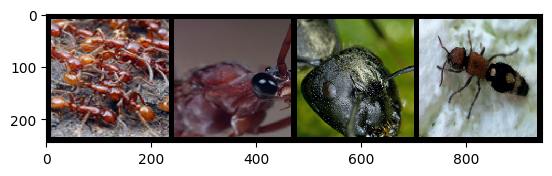

In [12]:
visualize_images(
    train_dataloader,
    mean=torch.tensor([0.485, 0.456, 0.406]),
    std=torch.tensor([0.229, 0.224, 0.225]),
)

There are two major transfer learning techniques depending on which parts of the network are updated using the new data:
1. Finetuning the full network
2. Finetuning only the last layer

First let's see how a randomly initialized model performs!

Epoch 0: Loss=0.8360771194833224
Epoch 1: Loss=0.8513959858749733
Epoch 2: Loss=0.7360819627027042
Epoch 3: Loss=0.7222550120510038
Epoch 4: Loss=0.7737596464938805
Epoch 5: Loss=0.9031231862599732
Epoch 6: Loss=0.6875820834128583
Epoch 7: Loss=0.7430938620303498
Epoch 8: Loss=0.7055021546414642
Epoch 9: Loss=0.7366838794751246
Epoch 10: Loss=0.6485941695873855
Epoch 11: Loss=0.6829608585990843
Epoch 12: Loss=0.6839953472868341
Epoch 13: Loss=0.7876194158538443
Epoch 14: Loss=0.6728394507873253
Epoch 15: Loss=0.6178941020711524
Epoch 16: Loss=0.8609910441226647
Epoch 17: Loss=0.6984787165630059
Epoch 18: Loss=0.6802496333591274
Epoch 19: Loss=0.6051309929519403
Epoch 20: Loss=0.8091336337269329
Epoch 21: Loss=0.6370078520696671
Epoch 22: Loss=0.7057565807319078
Epoch 23: Loss=0.6504217659840819
Epoch 24: Loss=0.7316548697284011
Test set: Avg. loss: 0.6464, Accuracy: 112/153 (73%)


(0.6463942382289888, tensor(73.2026, device='cuda:0'))

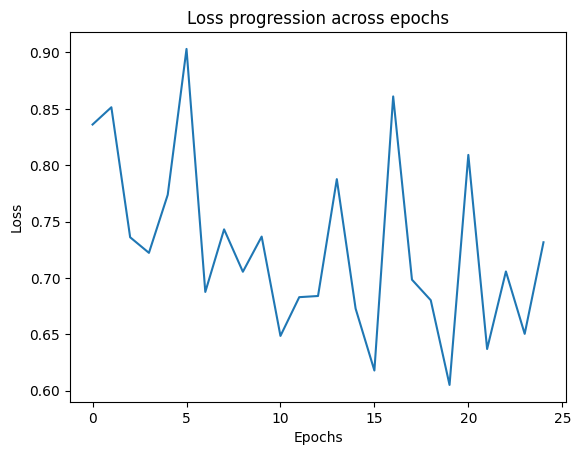

In [18]:
model = resnet18(num_classes=2).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the full network
Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. The rest of the training looks as usual, albeit normally using a significantly smaller learning rate.


In [13]:
import torch.nn as nn

class FinetuningFullModel(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.network = torchvision.models.resnet18(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes) # We need to adapt the last layer to the new number of classes

    def forward(self, x):
        return self.network(x)

Let's train it...

Epoch 0: Loss=0.5741354695780844
Epoch 1: Loss=0.5345795352191313
Epoch 2: Loss=0.6582193292456022
Epoch 3: Loss=0.4437942433888551
Epoch 4: Loss=0.3927324936900776
Epoch 5: Loss=0.6541801723193561
Epoch 6: Loss=0.47574367503192827
Epoch 7: Loss=0.510787411730309
Epoch 8: Loss=0.3980001726752666
Epoch 9: Loss=0.5048839020023702
Epoch 10: Loss=0.4579476835893192
Epoch 11: Loss=0.31725647149332725
Epoch 12: Loss=0.4619347118604623
Epoch 13: Loss=0.364228934026705
Epoch 14: Loss=0.5172606977008161
Epoch 15: Loss=0.3723662722031357
Epoch 16: Loss=0.3355296370535173
Epoch 17: Loss=0.4074047377188003
Epoch 18: Loss=0.5553998376975661
Epoch 19: Loss=0.45079156198370895
Epoch 20: Loss=0.33490312777337483
Epoch 21: Loss=0.4085526605495481
Epoch 22: Loss=0.6196786402953697
Epoch 23: Loss=0.47554839765424
Epoch 24: Loss=0.4193778942228432
Test set: Avg. loss: 0.4921, Accuracy: 133/153 (87%)


(0.4920655675028874, tensor(86.9281, device='cuda:0'))

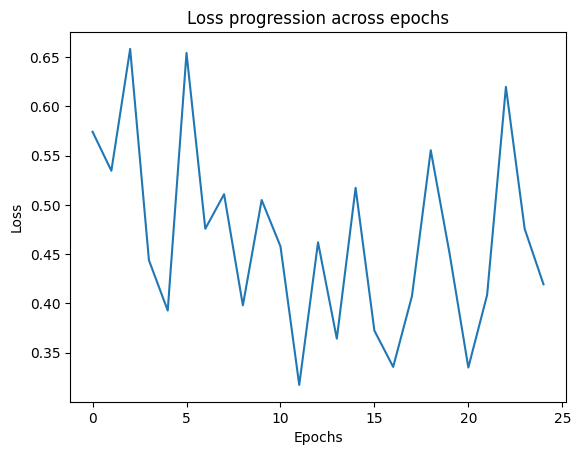

In [14]:
model = FinetuningFullModel(num_classes=2).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)


### Finetuning the last layer

Sometimes finetuning all the parameters of a large model is too expensive, or unstable. In those cases, one can alternatively 'freeze' some parts of the network, and train only the latter parts. Most often, just tuning the last layer is enough to get good enough results, with the optimal performance normally achieved by finetuning a few of the last layers.

In [15]:
class FinetuningLastLayer(nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        self.network = torchvision.models.resnet18(pretrained=True)
        for param in self.network.parameters():
            param.requires_grad = False # We set requires_grad=False to avoid computing gradients of those layers in the backward pass

        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes) # The new last layer has requires_grad=True by default

    def forward(self, x):
        return self.network(x)

Epoch 0: Loss=0.5671886831033425
Epoch 1: Loss=0.4468465972020001
Epoch 2: Loss=0.4870637105625184
Epoch 3: Loss=0.5509255646621106
Epoch 4: Loss=0.3269813207634648
Epoch 5: Loss=0.3096749838746962
Epoch 6: Loss=0.6606344044452808
Epoch 7: Loss=0.6255612435185762
Epoch 8: Loss=0.5273967750339967
Epoch 9: Loss=0.4508191244982061
Epoch 10: Loss=0.4729999323512931
Epoch 11: Loss=0.4004843002643253
Epoch 12: Loss=0.3442305233215028
Epoch 13: Loss=0.4097867012863643
Epoch 14: Loss=0.3879692388820599
Epoch 15: Loss=0.5375634678105106
Epoch 16: Loss=0.49967653276093427
Epoch 17: Loss=0.4905493609057587
Epoch 18: Loss=0.37876432676814864
Epoch 19: Loss=0.348483857538429
Epoch 20: Loss=0.4658800890921142
Epoch 21: Loss=0.5713908164151257
Epoch 22: Loss=0.36425205828912066
Epoch 23: Loss=0.35493913538692917
Epoch 24: Loss=0.464069531696131
Test set: Avg. loss: 0.5058, Accuracy: 127/153 (83%)


(0.5057580446377602, tensor(83.0065, device='cuda:0'))

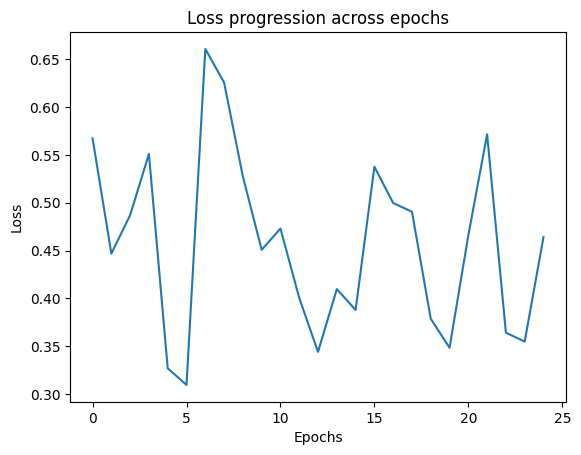

In [16]:
model = FinetuningLastLayer(num_classes=2).to(DEVICE)

# We normally use SGD to finetune a large model
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

plot_loss(
    fit(
        model,
        train_dataloader = train_dataloader,
        optimizer = optimizer,
        epochs = 25,
        device = DEVICE
    )
)

# predict with the trained model
predict(
    model,
    test_dataloader = test_dataloader,
    device = DEVICE
)